In [1]:
import networkx as nx
import sfttoolbox
import numpy as np
from dataclasses import dataclass, field
from typing import List, Dict, Tuple, Set, Optional, Callable

import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

import itertools

import os

from scipy.stats import gamma

sns.set_theme(style="whitegrid")


In [2]:
# staff capacity

@dataclass
class Staff:
    """Represents a staff member with their schedule and patient metrics."""
    name: int
    timetable: Dict[str, int]
    num_new_patients: int = 0
    num_fu_patients: int = 0
    wasted_time: List[int] = field(default_factory=list)
    annual_leave: Set[int] = field(default_factory=set)
    num_new_patients_this_week: int = 0
    num_ar_patients: int = 0
    ar_patients_this_week: int = 0
    num_fu_patients_this_week: int = 0

class StaffCapacity:
    """Manages the capacity and scheduling of staff members."""
    
    def __init__(self, staff_dict: Dict[int, Staff], fu_wait_list: Optional[Dict[int, List]] = None,
                 ar_wait_list: Optional[Dict[int, List]] = None, new_wait_list: Optional[List] = []):
        """
        Initializes the StaffCapacity with given staff, follow-up wait list, annual review wait list,
        and new patient wait list.
        
        Args:
            staff_dict (Dict[int, Staff]): Dictionary of staff ID to Staff objects.
            fu_wait_list (Optional[Dict[int, List]], optional): Follow-up wait list. Defaults to None.
            ar_wait_list (Optional[Dict[int, List]], optional): Annual review wait list. Defaults to None.
            new_wait_list (Optional[List], optional): New patient wait list. Defaults to None.
        """
        self.staff_dict = staff_dict

        self.new_wait_list = new_wait_list
        self.fu_wait_list = {name : [] for name in staff_dict} if not fu_wait_list else fu_wait_list
        self.ar_wait_list = {name : [] for name in staff_dict} if not ar_wait_list else ar_wait_list

        self.day_capacities = {name: 0 for name in staff_dict}

        
        self.patients_to_move_on = None
        self.last_update = -1


        self.metrics = {
            "number_of_new_patients": [],
            "number_of_ar_patients": [],
            "average_wait_time_new": [],
            "average_wait_time_fu": [],
            "average_wait_time_ar": [],
            "max_wait_time_new": [],
            "max_wait_time_fu": [],
            "max_wait_time_ar": [],
            "wait_time_per_staff": {staff.name: [] for staff in self.staff_dict.values()},
            "num_new_patients_this_week": {staff.name: [] for staff in self.staff_dict.values()},
            "num_fu_patients_this_week": {staff.name: [] for staff in self.staff_dict.values()},
            "ar_patients_this_week": {staff.name: [] for staff in self.staff_dict.values()},
            "max_wait_time_per_staff": {staff.name: [] for staff in self.staff_dict.values()},
            "current_load" : {staff.name: [] for staff in self.staff_dict.values()},
        }

        self.__name__ = self.__class__.__name__

    def get(self, resource: object, patient: object, day_num: int, day: str) -> bool:
        """
        Adds a patient to the appropriate wait list based on the resource type.
        
        Args:
            resource (object): The resource needed by the patient.
            patient (object): The patient object.
            day_num (int): The day number.
            day (str): The day name.
        
        Returns:
            bool: Always returns True.
        """
        if resource.type == "new":
            patient.appointment_duration = resource.time_required
#             50% 2 hours, 50% 3 scenario
#             if np.random.rand() > 0.5:
#                 patient.appointment_duration = resource.time_required - 1
#             else:
#                 patient.appointment_duration = resource.time_required

            self.new_wait_list.append(patient)
        elif resource.type == "fu":
            patient.appointment_duration = resource.time_required
            self.fu_wait_list[patient.assigned_staff].append(patient)
        elif resource.type == "ar":
            patient.appointment_duration = resource.time_required
            self.ar_wait_list[patient.assigned_staff].append(patient)

        return True

    def update_day(self, day_num: int, day: str) -> Optional[Dict[str, List]]:
        """
        Updates the schedule for a given day.
        
        Args:
            day_num (int): The day number.
            day (str): The day name.
        
        Returns:
            Optional[Dict[str, List]]: Dictionary of patients to be moved on.
        """
        if self.last_update == day_num:
            pass
        else:
            if day == "Mon":
                self.__update_metrics(day_num)
                self.__reset_weekly_metrics()
    
            self.patients_to_move_on = self.__see_patients(day_num, day)
            self.last_update = day_num

        return self.patients_to_move_on

    def __see_patients(self, day_num: int, day: str) -> Dict[str, List]:
        """
        Manages the patient appointments for a given day.
        
        Args:
            day_num (int): The day number.
            day (str): The day name.
        
        Returns:
            Dict[str, List]: Dictionary of patient types and their lists.
        """
        patient_type_priority = [self.__see_fu_patient, self.__see_ar_patient, self.__see_new_patient]
        type_of_patient = ["fu", "ar", "new"] # this is an awful hack...
        
#         reprioritising
#         if day in ["Wed"]:
#             patient_type_priority = [self.__see_new_patient, self.__see_fu_patient, self.__see_ar_patient]
#             type_of_patient = ["new", "fu", "ar"] # this is an awful hack...
        
        patients_to_return = {type_of_patient[i]: [] for i in range(len(patient_type_priority))}
        for staff_name, staff in self.staff_dict.items():
            if day_num not in staff.annual_leave and staff.timetable.get(day):
                self.day_capacities[staff_name] = staff.timetable[day]

                while self.day_capacities[staff_name] > 0:
                    for method_index, see_patient_method in enumerate(patient_type_priority):
                        patients = see_patient_method(day_num, staff)
                        if patients:
                            patients_to_return[type_of_patient[method_index]] += patients
                    else:
                        break # no more patients seen

                staff.wasted_time.append(self.day_capacities[staff.name])

        return patients_to_return

    def __see_fu_patient(self, day_num: int, staff: Staff) -> List[object]:
        """
        Manages follow-up patient appointments.
        
        Args:
            day_num (int): The day number.
            staff (Staff): The staff member.
        
        Returns:
            List[object]: List of follow-up patients to move on.
        """
        patients_to_move_on = []
        for patient_index, patient in enumerate(self.fu_wait_list[staff.name]):
            if (day_num - patient.date_last_appt) > patient.delay_between_appts:
                appointment_duration = patient.appointment_duration
                
                if self.day_capacities[staff.name] - appointment_duration < 0:
                    break
                else:
                    patient = self.fu_wait_list[staff.name].pop(patient_index)
                    patient.num_appointments += 1
                    patient.date_last_appt = day_num
    
                    if patient.num_appointments < 6: # TODO: parameterise this from resource
                        self.fu_wait_list[staff.name].append(patient)
                    else:
                        patients_to_move_on.append(patient)
#                         # 50% of ar seen scenario:
# #                         if np.random.rand() > 0.5:
# #                             patients_to_move_on.append(patient)
#                         # 100% ar removed scenario
#                         pass
    
                    self.day_capacities[staff.name] -= appointment_duration
                    staff.num_fu_patients += 1
                    staff.num_fu_patients_this_week += 1
        
        return patients_to_move_on

    def __see_ar_patient(self, day_num: int, staff: Staff) -> None:
        """
        Manages annual review patient appointments.
        
        Args:
            day_num (int): The day number.
            staff (Staff): The staff member.
        """
        for patient_index, patient in enumerate(self.ar_wait_list[staff.name]):
            if (day_num - patient.date_last_appt) > 365:
                appointment_duration = patient.appointment_duration
                
                if self.day_capacities[staff.name] - appointment_duration < 0:
                    break
                else:
                    patient = self.ar_wait_list[staff.name].pop(patient_index)
                    patient.num_appointments += 1
                    patient.date_last_appt = day_num
    
                    patient.num_annual_reviews += 1
    
                    self.ar_wait_list[staff.name].append(patient)
    
                    self.day_capacities[staff.name] -= appointment_duration
                    staff.ar_patients_this_week += 1
                    staff.num_ar_patients += 1

    def __see_new_patient(self, day_num: int, staff: Staff) -> List[object]:
        """
        Manages new patient appointments.
        
        Args:
            day_num (int): The day number.
            staff (Staff): The staff member.
        
        Returns:
            List[object]: List of new patients to move on.
        """
        patients_to_move_on = []

        for patient_index, patient in enumerate(self.new_wait_list):

            appointment_duration = patient.appointment_duration
            if self.day_capacities[staff.name] - appointment_duration < 0:
                break
            else:
                patient = self.new_wait_list.pop(0)

                patient.assigned_staff = staff.name
                patient.initial_assessment_date = day_num
                patient.num_appointments += 1
                patient.date_last_appt = day_num

                self.day_capacities[staff.name] -= appointment_duration
                staff.num_new_patients_this_week += 1
                staff.num_new_patients += 1

                patients_to_move_on.append(patient)

        return patients_to_move_on

    def __update_metrics(self, day_num: int) -> None:
        """
        Updates the metrics for the current week.
        
        Args:
            day_num (int): The day number.
        """
        # TODO: Tidy this up
        if len(self.new_wait_list) > 0:
            # avg_wait_time_new = sum([day_num - p.initial_date for p in self.new_wait_list]) / len(self.new_wait_list)
            # self.metrics["average_wait_time_new"].append(avg_wait_time_new)

            max_wait_time_new = max([day_num - p.initial_date for p in self.new_wait_list])
            self.metrics["max_wait_time_new"].append(max_wait_time_new)
            
            self.metrics["number_of_new_patients"].append(len(self.new_wait_list))
        else:
            # self.metrics["average_wait_time_new"].append(0)
            self.metrics["max_wait_time_new"].append(0)

        if num_ars := sum([len(ar_list) for ar_list in self.ar_wait_list.values()]):
            avg_wait_time_ar = sum([day_num - p.date_last_appt for s in self.ar_wait_list for p in self.ar_wait_list[s]]) / num_ars
            self.metrics["average_wait_time_ar"].append(avg_wait_time_ar)

            max_wait_time_ar = max([day_num - p.date_last_appt for s in self.ar_wait_list for p in self.ar_wait_list[s]])
            self.metrics["max_wait_time_ar"].append(max_wait_time_ar)
            
            self.metrics["number_of_ar_patients"].append(num_ars)
        else:
            self.metrics["average_wait_time_ar"].append(0)
            self.metrics["max_wait_time_ar"].append(0)          
            

        total_wait_time = 0
        total_wait_time_new = 0
        num_patients = 0
        max_wait_time_fu = 0
        for staff in self.staff_dict.values():
            self.metrics["num_fu_patients_this_week"][staff.name].append(staff.num_fu_patients_this_week)
            self.metrics["num_new_patients_this_week"][staff.name].append(staff.num_new_patients_this_week)
            self.metrics["ar_patients_this_week"][staff.name].append(staff.ar_patients_this_week)
            self.metrics["current_load"][staff.name].append(len(self.fu_wait_list[staff.name]))

            staff_wait_times = [day_num - patient.date_last_appt for patient in self.fu_wait_list[staff.name]]
            
            
            new_patient_wait_times = [patient.initial_assessment_date - patient.initial_date for patient in self.fu_wait_list[staff.name]]

            if staff_wait_times:
                max_wait_time_fu = max(max_wait_time_fu, max(staff_wait_times))
                max_staff_wait_time = max(staff_wait_times)

                total_wait_time += sum(staff_wait_times)
                num_patients += len(staff_wait_times)
                
                total_wait_time_new += sum(new_patient_wait_times)

                self.metrics["wait_time_per_staff"][staff.name].append(sum(staff_wait_times) / len(staff_wait_times))
                self.metrics["max_wait_time_per_staff"][staff.name].append(max_staff_wait_time)
            else:
                self.metrics["wait_time_per_staff"][staff.name].append(0)
                self.metrics["max_wait_time_per_staff"][staff.name].append(0)

        if num_patients != 0:
            self.metrics["average_wait_time_fu"].append(total_wait_time / num_patients)
            self.metrics["max_wait_time_fu"].append(max_wait_time_fu)
            self.metrics["average_wait_time_new"].append(total_wait_time_new / num_patients)
        else:
            self.metrics["average_wait_time_fu"].append(0)
            self.metrics["max_wait_time_fu"].append(0)
            self.metrics["average_wait_time_new"].append(0)
            
    def __reset_weekly_metrics(self) -> None:
        """
        Resets the weekly metrics for all staff members.
        """
        for staff in self.staff_dict.values():
            staff.new_patients_this_week = 0
            staff.num_new_patients_this_week = 0
            staff.ar_patients_this_week = 0
            staff.num_fu_patients_this_week = 0


class TypeStaffCapacity:
    """Manages the capacity and scheduling of staff members based on patient types."""
    
    def __init__(self, named_type: str, control_staff_capacity: StaffCapacity):
        """
        Initializes the TypeStaffCapacity with the given patient type and control staff capacity.
        
        Args:
            named_type (str): The patient type to manage.
            control_staff_capacity (StaffCapacity): The control staff capacity object.
        """
        self.named_type = named_type
        self.control_staff_capacity = control_staff_capacity
        
        self.__name__ = self.__class__.__name__

    def get(self, resource: object, patient: object, day_num: int, day: str) -> bool:
        """
        Adds a patient to the appropriate wait list based on the resource type.
        
        Args:
            resource (object): The resource needed by the patient.
            patient (object): The patient object.
            day_num (int): The day number.
            day (str): The day name.
        
        Returns:
            bool: Always returns True.
        """
        self.control_staff_capacity.get(resource, patient, day_num, day)
        return True

    def update_day(self, day_num: int, day: str) -> List[object]:
        """
        Updates the schedule for a given day.
        
        Args:
            day_num (int): The day number.
            day (str): The day name.
        
        Returns:
            List[object]: List of patients to be moved on for the specified type.
        """
        patients_to_return = self.control_staff_capacity.update_day(day_num, day)
        return patients_to_return[self.named_type]


In [3]:
# patients and distributions

@sfttoolbox.DES.distribution_wrapper
def uniform() -> float:
    """
    Generates a random number from a uniform distribution.
    
    Returns:
        float: A random number from a uniform distribution.
    """
    return np.random.uniform()

@dataclass
class AppointmentDuration:
    """
    Represents the duration and type of an appointment.
    
    Attributes:
        time_required (float): The time required for the appointment.
        type (str): The type of the appointment.
        num_required (int): The number of appointments required. Defaults to 1.
    """
    time_required: float
    type: str
    num_required: int = 1
    
    def __post_init__(self):
        """Initializes the name attribute for the class."""
        self.__name__ = self.__class__.__name__

new_duration = AppointmentDuration(3, "new")
fu_duration = AppointmentDuration(0.75, "fu", 6)
ar_duration = AppointmentDuration(0.75, "ar")

@dataclass
class Patient:
    """
    Represents a patient with their appointment history and details.
    
    Attributes:
        id (int): The patient ID.
        initial_date (int): The initial date the patient was added.
        pathway (List[str]): The patient's pathway. Defaults to an empty list.
        num_appointments (int): The number of appointments the patient has had. Defaults to 0.
        assigned_staff (Optional[int]): The ID of the staff assigned to the patient. Defaults to None.
        appointment_duration (float): The duration of the appointment. Defaults to 0.
        delay_between_appts (int): The delay between appointments. Defaults to 25.
        date_last_appt (Optional[int]): The date of the last appointment. Defaults to None.
        initial_assessment_date (Optional[int]): The date of the initial assessment. Defaults to None.
        num_annual_reviews (int): The number of annual reviews the patient has had. Defaults to 0.
    """
    id: int
    initial_date: int
    pathway: list[str] = field(default_factory=list)

    num_appointments: int = 0
    assigned_staff: int = None
    appointment_duration: float = 0
    # delay_between_appts: int = 24
    # scenario
    delay_between_appts: int = 14
    date_last_appt: int = None
    initial_assessment_date: int = None
    num_annual_reviews: int = 0

#     def __post_init__(self):
#         duration = 3 if np.random.rand() > 0.5 else 2
#         self.appointment_durations = (duration, 0.75)


class PatientGenerator:
    """
    Generates patients based on a specified distribution.
    
    Attributes:
        id (int): The next patient ID to be assigned.
        distribution (callable): A function that generates the number of patients to be created.
    """
    def __init__(self) -> None:
        """Initializes the PatientGenerator with a gamma distribution for patient creation."""
        self.id = 0
        # This was the optimum fit for the monthly data, converted to weekly
        self.distribution = lambda : gamma.rvs(a=13.184946215112486, loc=53.53144224603051, scale=4.21688470452238) * 12 / 52

    def generate_patients(self, day_num: int, day: str) -> List[Patient]:
        """
        Generates patients for a given day.
        
        Args:
            day_num (int): The day number.
            day (str): The day name.
        
        Returns:
            List[Patient]: A list of generated patients.
        """
        patients = []
        if day == "Mon":
            for _ in range(int(self.distribution())):
                patients.append(Patient(self.id, day_num))
                self.id += 1

        return patients


In [4]:
# graph

def generate_graph(new_staff_capacity: TypeStaffCapacity,
                   fu_staff_capacity: TypeStaffCapacity,
                   ar_staff_capacity: TypeStaffCapacity,
                   new_duration: AppointmentDuration,
                   fu_duration: AppointmentDuration,
                   ar_duration: AppointmentDuration,
                   uniform: Callable[[], float]
                   ) -> nx.DiGraph:
    """
    Generates a directed graph representing a patient care process.

    Args:
        new_staff_capacity (int): The capacity for new patient staff.
        fu_staff_capacity (int): The capacity for follow-up patient staff.
        ar_staff_capacity (int): The capacity for annual review patient staff.
        new_duration (object): The appointment duration for new patients.
        fu_duration (object): The appointment duration for follow-up patients.
        ar_duration (object): The appointment duration for annual review patients.
        uniform (Callable[[], float]): A callable that returns a random number from a uniform distribution.

    Returns:
        nx.DiGraph: A directed graph with nodes and edges representing the patient care process.
    """
    
    edges = [
        ("Initial Assessment - 3 hours", "Diagnosed"),
        
        ("Diagnosed", "Discharged", {"probability": 0.1}),
        ("Diagnosed", "Wants prescription?", {"probability": 0.9}),
    
        ("Wants prescription?", "Discharged", {"probability": 0.15}),
        ("Wants prescription?", "FU appts", {"probability": 0.85}),
    
        ("FU appts", "GP appts"),
    
        ("GP appts", "Annual Review"),
        # ("Annual Review", "End of simulation")
    ]
    
    nodes = [
        ("Initial Assessment - 3 hours", {"capacity": new_staff_capacity, "resource": new_duration}),
        ("Diagnosed", {"distribution": uniform}),
        ("Wants prescription?", {"distribution": uniform}),
        ("FU appts", {"capacity": fu_staff_capacity, "resource": fu_duration}),
        ("Annual Review", {"capacity": ar_staff_capacity, "resource": ar_duration}),
    ]
    
    G = nx.DiGraph()
    G.add_edges_from(edges)
    G.add_nodes_from(nodes)
    
    return G

In [5]:
# set up simulation

def generate_annual_leave(simulation_years: int) -> Set[int]:
    """
    Generate simulated annual leave days for a given number of years.

    Parameters:
    simulation_years (int): Number of years to simulate.

    Returns:
    Set[int]: List of simulated annual leave days.

    The function simulates annual leave days for a given number of years.
    It randomly selects approximately 20% of weekdays within each year.
    """
    days_in_sim = np.arange(1, 366, 1)
    al = []
    for years in range(simulation_years):
        offset = years * 365
        d = days_in_sim + offset
        weekdays = d[(d % 7 != 0)  & ~(d % 7 == 6)]

        al += list(np.random.choice(weekdays, weekdays.shape[0]//5)) # 20 % leave per year
    return set(al)

def setup_simulation(simulation_years: int,
                     staff_list: List[Staff],
                     resources: AppointmentDuration,
                     uniform: Callable[[], float],
                     ) -> Tuple[sfttoolbox.DES.Simulation, StaffCapacity]:
    """
    Set up the simulation environment with given parameters.

    Parameters:
    simulation_years (int): Number of years to simulate.
    staff_list (List[Any]): List of staff objects.
    resources (Dict[str, Any]): Dictionary of resources for different appointment types.
    uniform (Any): A uniform distribution function.

    Returns:
    Tuple[Any, Any]: A tuple containing the simulation object and the staff capacity control.
    """

    staff_total_hours = {staff.name: sum(staff.timetable.values()) for staff in staff_list}
    staff_fractions = {staff.name: staff_total_hours[staff.name] / sum(staff_total_hours.values()) for staff in staff_list}

    al_review = {staff.name:[] for staff in staff_list}

    # total number of al review
    initial_al_review = 52 # taken from spreadsheet
#     initial_al_review = 26 # 50 % removed
    initial_al_review = 0
    name = 0

    for name, last_appt in enumerate(np.random.uniform(365, size=initial_al_review).astype(int)):
        assigned_staff=np.random.choice(list(staff_fractions.keys()), p=list(staff_fractions.values()))
        al_review[assigned_staff].append(
            Patient(
                initial_date=-last_appt - 100,
                id=name,
                date_last_appt=-last_appt,
                num_appointments=6,
                assigned_staff=assigned_staff,
                appointment_duration=0.75,
            )
        )

    fu_lists = {staff.name:[] for staff in staff_list}

    # fu list
    initial_fu_list = 135 # from spreadsheet

    # 30 days since assessment?
    for name, last_appt in enumerate(np.random.uniform(30, size=initial_fu_list).astype(int), name+1):
        assigned_staff=np.random.choice(list(staff_fractions.keys()), p=list(staff_fractions.values()))

        num_appts = int(np.random.uniform(5))
        fu_lists[assigned_staff].append(
            Patient(
                initial_date= -last_appt - 465,
                id=name,
                date_last_appt=-last_appt,
                num_appointments=num_appts,
                assigned_staff=assigned_staff,
                appointment_duration=0.5,
                initial_assessment_date = -last_appt - 100
            )
        )
    for staff in staff_list:
        fu_lists[staff.name].sort(key=lambda p: p.date_last_appt)
    
    waiting_for_assessment = [
        Patient(
            id = name,
            initial_date = - days_waited,
            appointment_duration=3,
        ) for name, days_waited in enumerate(np.genfromtxt("raw_data/waiting_for_assessment.csv", delimiter=",")[1:, 1], name+1)
    ]

    staff_capacity_control = StaffCapacity(dict(enumerate(staff_list)), fu_wait_list=fu_lists, ar_wait_list=al_review, new_wait_list=waiting_for_assessment)
    
    new_staff_capacity = TypeStaffCapacity("new", staff_capacity_control)
    fu_staff_capacity = TypeStaffCapacity("fu", staff_capacity_control)
    ar_staff_capacity = TypeStaffCapacity("ar", staff_capacity_control)
    
    G = generate_graph(new_staff_capacity, fu_staff_capacity, ar_staff_capacity, *resources.values(), uniform)
    pg = PatientGenerator()
    pg.id = name + 1 + len(waiting_for_assessment)

    simulation_length = 365*simulation_years

    return sfttoolbox.DES.Simulation(G, pg, simulation_length), staff_capacity_control


In [13]:
simulation_years = 5

sims = []
scs = []

for index in range(100):
    staff_list = [
        Staff(0, {"Mon": 4, "Tue": 4, "Wed": 4, "Thu":4, "Fri":4}, annual_leave=generate_annual_leave(simulation_years)),
        Staff(1, {"Mon": 4, "Tue": 4, "Wed": 4, "Thu":4, "Fri":4}, annual_leave=generate_annual_leave(simulation_years)),
        Staff(2, {"Mon": 4, "Tue": 4, "Wed": 4, "Thu":4}, annual_leave=generate_annual_leave(simulation_years)),
    ]# + [
    #     Staff(i, {"Mon": 8, "Tue": 6, "Wed": 6, "Thu":0, "Fri":0}, annual_leave=generate_annual_leave(simulation_years))
    #     for i in range(3, 8)
    # ]
#     Staff(i, {"Mon": 4, "Tue": 4, "Wed": 4, "Thu":4, "Fri":4}, annual_leave=generate_annual_leave(simulation_years))
# for i in range(3, 16)
#     ]
    
    resources = {"new": new_duration, "fu": fu_duration, "ar":ar_duration}
    
    sim, sc = setup_simulation(simulation_years=simulation_years, staff_list=staff_list, resources=resources, uniform=uniform)
    sim.run_simulation()

    sims.append(sim)
    scs.append(sc)

# TODO: Add in functionality for DNAs?

In [14]:
# Scenarios:
#  - Current scenario (3 news per week)
#  - New scenario, no amount of news?
#  - Another X full time members of staff
#  - 50% of annual reviews gone
#  - 100% of annual reviews gone
#  - FU appts 30 mins
#  - FU appts 15 mins
#  - 50% of news 2 hours, rest 3 hours
#  - reprioritise
#  - combination approaches

# Summary table, max wait time of new, ar and fu
# Ratio after 5 years
# Average wasted time for FT, PT
# FU caseload

## Plotting

In [15]:
def save_pi_values(ax, labels, filename):
    intervals = []
    heights = []
    for line in ax.get_children():
        if isinstance(line, plt.Line2D):
            l = line.get_ydata()
            if l[1] - l[0] != 0:

                intervals.append(line.get_ydata())
                
        elif isinstance(line, plt.Rectangle):
            h = line.get_height()
            heights.append(h)
    
    zipped_metrics =  [(lb, ub, mean) for (lb, ub), mean in zip(intervals, heights)]
    
    pd.DataFrame(dict(zip(labels,zipped_metrics))).rename({0:"lb", 1:"ub", 2:"mean"}).T.to_csv(f"{filename}.csv")

In [16]:
run_label = ""
num_staff = len(staff_list)

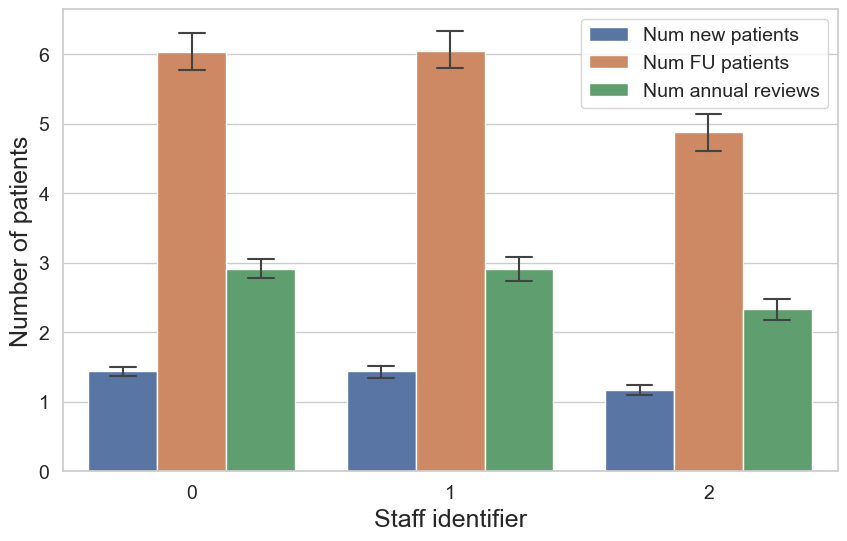

In [17]:
# patients ratio

plt.figure(figsize=(10,6))

num_patients = np.array(
    [
        [
            list(sc.metrics["num_new_patients_this_week"].values()),
            list(sc.metrics["num_fu_patients_this_week"].values()),
            list(sc.metrics["ar_patients_this_week"].values())
        ] for sc in scs
    ]
)

average_patients = num_patients.mean(axis=3)

dfs = []
for staff in staff_list:
    df = pd.DataFrame(average_patients[:, :, staff.name], columns = ["Num new patients", "Num FU patients", "Num annual reviews"])
    df["Staff"] = staff.name

    dfs.append(df)

df = pd.concat(dfs)
df = pd.melt(df, id_vars = "Staff", value_vars = ["Num new patients", "Num FU patients", "Num annual reviews"])

ax = sns.barplot(df, x= "Staff", y = "value", hue="variable", errorbar=('pi', 95), capsize=0.1, errwidth=1.5)
plt.xlabel("Staff identifier")
plt.ylabel("Number of patients")

# plt.title("Average number of patients per week")
ax.get_legend().set_title("")


save_pi_values(ax, itertools.product(["new", "fu", "ar"], [*range(num_staff)]), f"{run_label}_patients_ratio")



plt.legend(fontsize=14)
ax.xaxis.label.set_size(18)
ax.yaxis.label.set_size(18)
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)


plt.savefig("images/patients_per_week.png", dpi=600)

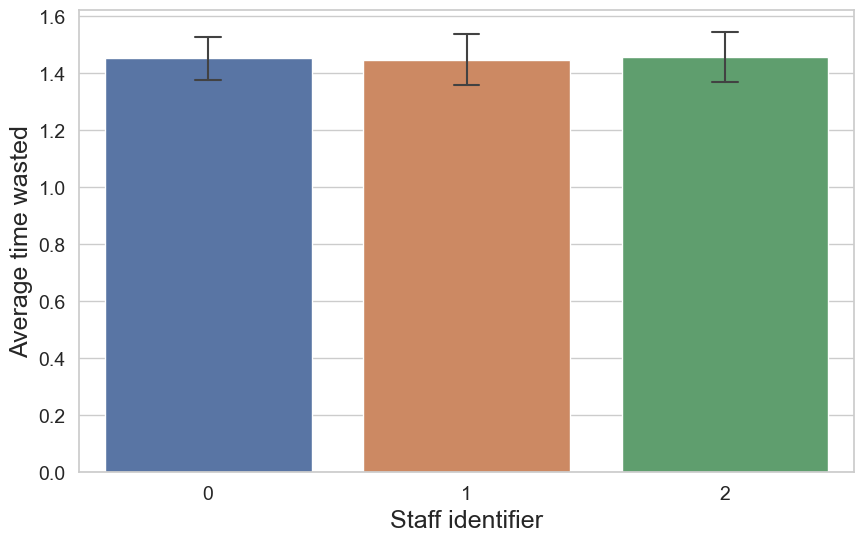

In [18]:
# wasted time

plt.figure(figsize=(10,6))

wasted_time = np.array([[np.mean(sc.staff_dict[i].wasted_time) for i in range(num_staff)] for sc in scs])

ax = sns.barplot(pd.DataFrame(wasted_time), errorbar=('pi', 95), capsize=0.1, errwidth=1.5)
plt.xlabel("Staff identifier")
plt.ylabel("Average time wasted")
# plt.title("Average time wasted per day")


# plt.legend(fontsize=14)
ax.xaxis.label.set_size(18)
ax.yaxis.label.set_size(18)
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)

save_pi_values(ax, [*range(num_staff)], f"{run_label}_wasted_time")

plt.savefig("images/time_wasted.png", dpi=600)


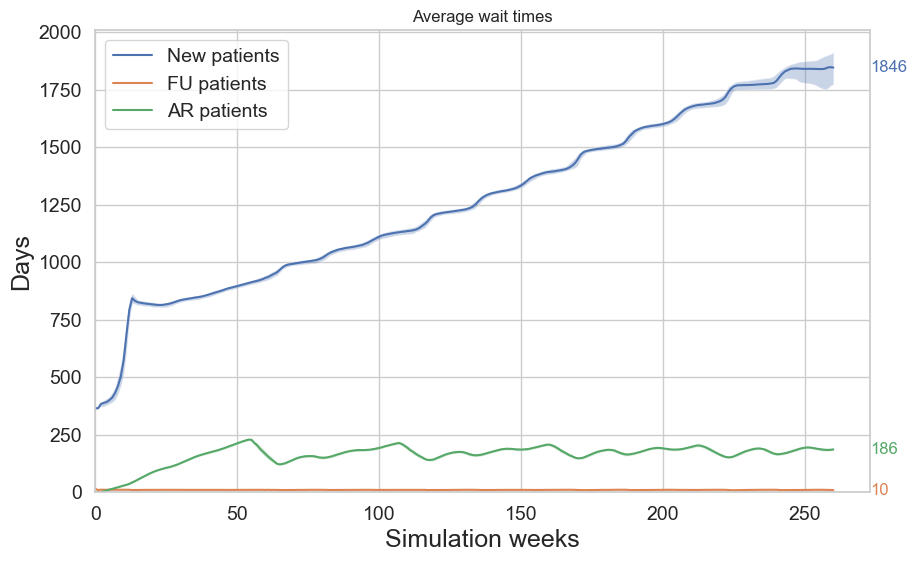

In [19]:
plt.figure(figsize=(10,6))

def plot_end_points(ax):
    for l in ax.lines:
        y = l.get_ydata()
        if len(y)>0:
            ax.annotate(f'{y[-1]:.0f}', xy=(1,y[-1]), xycoords=('axes fraction', 'data'),
                        ha='left', va='center', color=l.get_color())

x = np.array([sc.metrics["average_wait_time_new"] for sc in scs])
ax = sns.lineplot(np.median(x, axis=0), label= "New patients")
plt.fill_between(range(len(x[0])), np.percentile(x, 2.5, axis=0), np.percentile(x, 97.5, axis=0), alpha=0.3)

x = np.array([sc.metrics["average_wait_time_fu"] for sc in scs])
sns.lineplot(np.median(x, axis=0), label= "FU patients")
plt.fill_between(range(len(x[0])), np.percentile(x, 2.5, axis=0), np.percentile(x, 97.5, axis=0), alpha=0.3)

x = np.array([sc.metrics["average_wait_time_ar"] for sc in scs])
sns.lineplot(np.median(x, axis=0), label= "AR patients")
plt.fill_between(range(len(x[0])), np.percentile(x, 2.5, axis=0), np.percentile(x, 97.5, axis=0), alpha=0.3)

plt.legend()

plt.xlabel("Simulation weeks")
plt.ylabel("Days")
plt.title("Average wait times")

plt.xlim(0)
plt.ylim(0)

plot_end_points(ax)

ax.axvline(x=1825, linestyle="dashed", c="black")



plt.legend(fontsize=14)
ax.xaxis.label.set_size(18)
ax.yaxis.label.set_size(18)
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)



plt.savefig("images/wait_times.png", dpi=600)

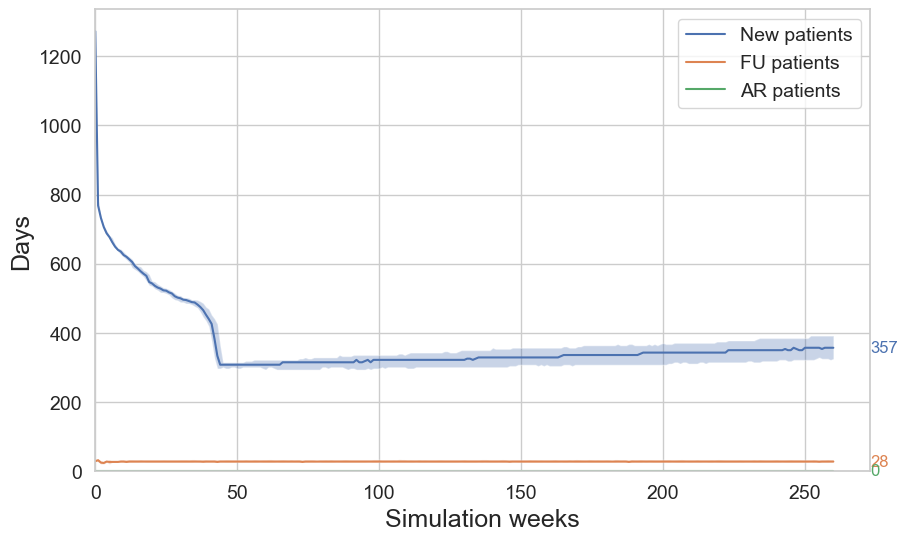

In [168]:
plt.figure(figsize=(10,6))

x = np.array([sc.metrics["max_wait_time_new"] for sc in scs])
ax = sns.lineplot(np.median(x, axis=0), label= "New patients")
x1 = (np.percentile(x, 2.5, axis=0), np.percentile(x, 97.5, axis=0))
plt.fill_between(range(len(x[0])), np.percentile(x, 2.5, axis=0), np.percentile(x, 97.5, axis=0), alpha=0.3)

x = np.array([sc.metrics["max_wait_time_fu"] for sc in scs])
sns.lineplot(np.median(x, axis=0), label= "FU patients")
x2 = (np.percentile(x, 2.5, axis=0), np.percentile(x, 97.5, axis=0))
plt.fill_between(range(len(x[0])), np.percentile(x, 2.5, axis=0), np.percentile(x, 97.5, axis=0), alpha=0.3)

x = np.array([sc.metrics["max_wait_time_ar"] for sc in scs])
sns.lineplot(np.median(x, axis=0), label= "AR patients")
x3 = (np.percentile(x, 2.5, axis=0), np.percentile(x, 97.5, axis=0))
plt.fill_between(range(len(x[0])), np.percentile(x, 2.5, axis=0), np.percentile(x, 97.5, axis=0), alpha=0.3)

plt.legend()

plt.xlabel("Simulation weeks")
plt.ylabel("Days")
# plt.title("Maximum wait times")

plt.xlim(0)
plt.ylim(0)

plot_end_points(ax)

ys = [l.get_ydata()[-1] for l in ax.lines]
ys = [(a,b,c) for a, (b,c) in zip(ys,[(x[0][-1], x[1][-1]) for x in [x1,x2,x3]])]
pd.DataFrame(dict(zip(["new", "fu", "ar"], ys))).rename({0:"median", 1:"2.5th percentile", 2:"97.5th percentile"}).T.to_csv(f"{run_label}_max_wait.csv")




plt.legend(fontsize=14)
ax.xaxis.label.set_size(18)
ax.yaxis.label.set_size(18)
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)





plt.savefig("images/max_wait_times.png", dpi=600)

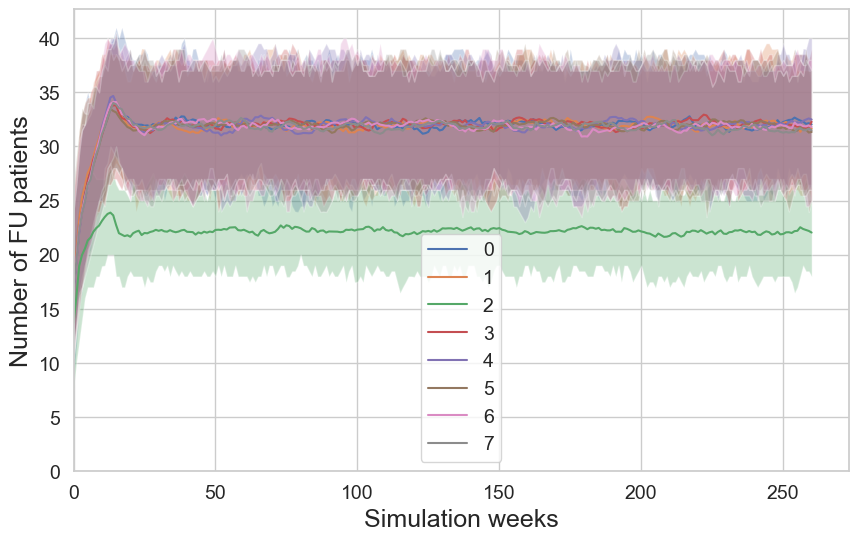

In [171]:
plt.figure(figsize=(10,6))

current_load = np.array([sc.metrics["current_load"] for sc in scs])

staff_name = current_load[0].keys()

x = np.array([[vals[name] for vals in current_load] for name in staff_name])

for name in staff_name:
    ax = sns.lineplot(np.mean(x, axis=1)[name], label=name)
    plt.fill_between(range(len(x[name][0])), np.percentile(x, 2.5, axis=1)[name], np.percentile(x, 97.5, axis=1)[name], alpha=0.3)


plt.legend()

plt.xlabel("Simulation weeks")
plt.ylabel("Number of FU patients")

# plt.title("Total number of FU patients per staff")

plt.xlim(0)
plt.ylim(0)



# plot_end_points(ax)

ys = [l.get_ydata()[-1] for l in ax.lines]
pd.DataFrame(zip(["new", "fu", "ar"], ys))#.to_csv("current_approach_max_wait.csv")



plt.legend(fontsize=14)
ax.xaxis.label.set_size(18)
ax.yaxis.label.set_size(18)
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)



plt.savefig("images/case_load.png")

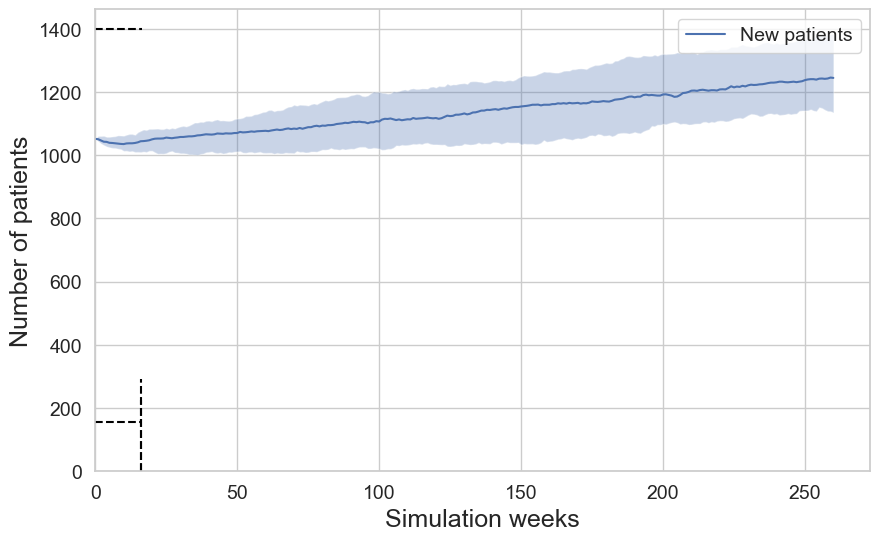

In [172]:
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10,6))

x = np.array([sc.metrics["number_of_new_patients"] for sc in scs])
ax = sns.lineplot(np.median(x, axis=0), label= "New patients")
x1 = (np.percentile(x, 2.5, axis=0), np.percentile(x, 97.5, axis=0))
plt.fill_between(range(len(x[0])), np.percentile(x, 2.5, axis=0), np.percentile(x, 97.5, axis=0), alpha=0.3)

plt.xlabel("Simulation weeks")
plt.ylabel("Number of patients")

plt.axvline(16, 0, 0.199, color='black', linestyle='dashed')
plt.axhline(1400, 0, 0.060, color='black', linestyle='dashed')


x = np.array([sc.metrics["number_of_ar_patients"] for sc in scs])
ax = sns.lineplot(np.median(x, axis=0), label= "AR patients", color='g')
x1 = (np.percentile(x, 2.5, axis=0), np.percentile(x, 97.5, axis=0))
plt.fill_between(range(len(x[0])), np.percentile(x, 2.5, axis=0), np.percentile(x, 97.5, axis=0), alpha=0.3, color='g')

plt.axvline(16, 0, 0.155, color='black', linestyle='dashed')
plt.axhline(155, 0, 0.060, color='black', linestyle='dashed')

plt.legend(fontsize=14)
ax.xaxis.label.set_size(18)
ax.yaxis.label.set_size(18)
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)

plt.xlim(0)
plt.ylim(0)

plt.savefig("images/validation.png")

## Meta analysis

In [173]:
csvs = [x for x in os.listdir() if x.endswith(".csv")]

In [179]:
csvs = [csv for csv in csvs if csv.startswith("8_6_6") and "6_more_staff" not in csv and "4_more_staff" not in csv and "3_more_staff" not in csv] 

# csvs

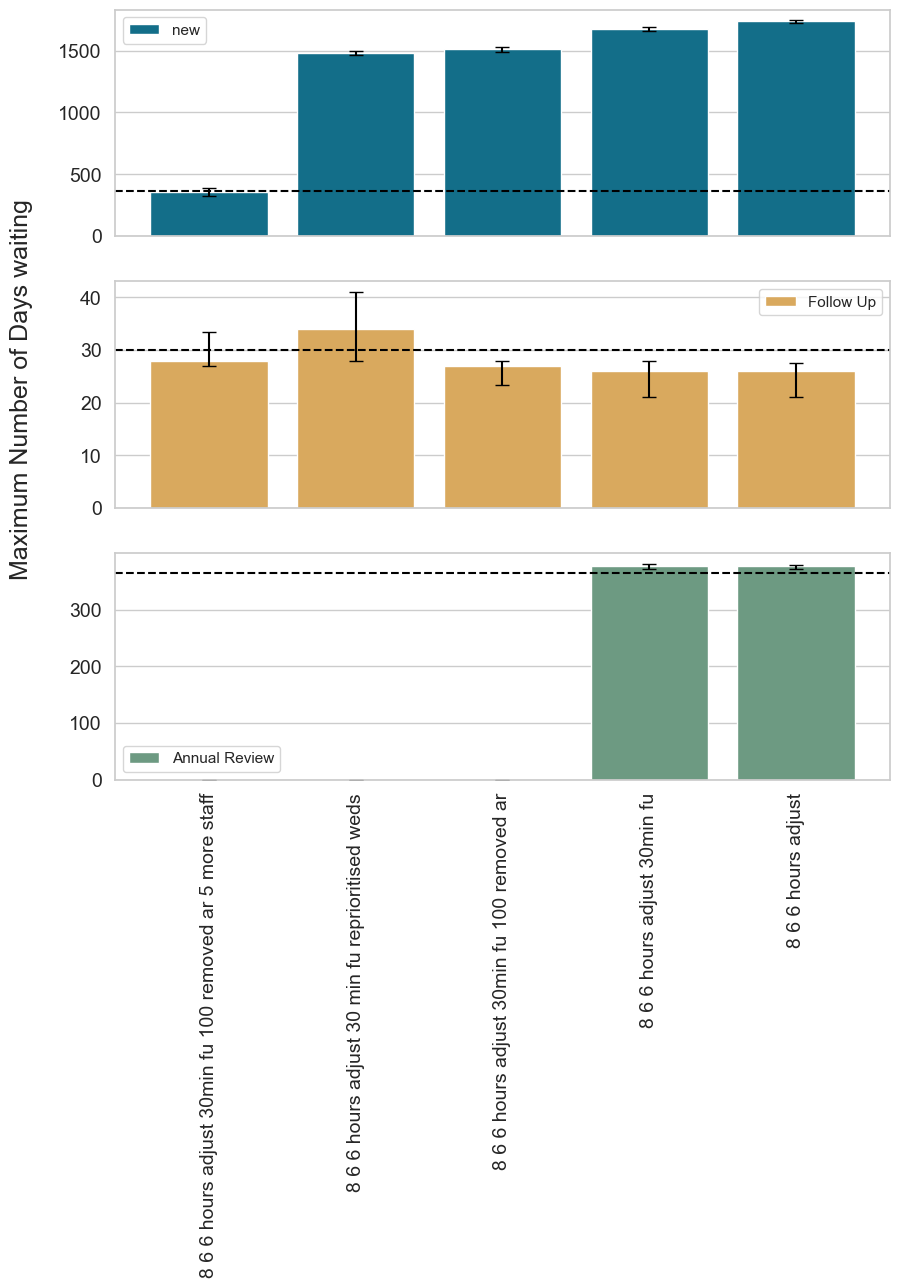

In [180]:
# max wait times

dfs = []

for csv in csvs:
    if "max_wait" in csv:
        df = pd.read_csv(csv, index_col=0)
        df["source"] = csv[:-13].replace("_", " ")
        dfs.append(df)
        

df = pd.concat(dfs)
data = df[df.index == "new"].sort_values(by="median")

fig, axs = plt.subplots(3, 1, figsize=(10, 10))

sns.barplot(data, x="source", y="median", color=sfttoolbox.team_colours["blue"]["hex"], ax=axs[0], label="new")
axs[0].xaxis.set_visible(False)
axs[0].axhline(y=365, linestyle="dashed", color="black")

for row in data[["median", "2.5th percentile", "97.5th percentile"]].reset_index(drop=True).iterrows():
    axs[0].errorbar(
        row[0], row[1]["median"], 
        yerr=[[row[1]["median"] - row[1]["2.5th percentile"]], [row[1]["97.5th percentile"] - row[1]["median"]]], 
        fmt='none', capsize=5, color='black', lw=1.5
    )


df_tmp = df[df.index == "fu"].set_index("source").loc[data["source"]].reset_index()
sns.barplot(
    df_tmp,
    x = "source", y="median", color=sfttoolbox.team_colours["yellow"]["hex"], ax=axs[1], label="Follow Up"
)
axs[1].xaxis.set_visible(False)
axs[1].axhline(y=30, linestyle="dashed", color="black")

for row in df_tmp[["median", "2.5th percentile", "97.5th percentile"]].reset_index(drop=True).iterrows():
    axs[1].errorbar(
        row[0], row[1]["median"], 
        yerr=[[row[1]["median"] - row[1]["2.5th percentile"]], [row[1]["97.5th percentile"] - row[1]["median"]]], 
        fmt='none', capsize=5, color='black', lw=1.5
    )

df_tmp = df[df.index == "ar"].set_index("source").loc[data["source"]].reset_index()
sns.barplot(
    df_tmp,
    x = "source", y="median", color=sfttoolbox.team_colours["green"]["hex"], ax=axs[2], label="Annual Review"
)
axs[2].axhline(y=365, linestyle="dashed", color="black")

for row in df_tmp[["median", "2.5th percentile", "97.5th percentile"]].reset_index(drop=True).iterrows():
    axs[2].errorbar(
        row[0], row[1]["median"], 
        yerr=[[row[1]["median"] - row[1]["2.5th percentile"]], [row[1]["97.5th percentile"] - row[1]["median"]]], 
        fmt='none', capsize=5, color='black', lw=1.5
    )

plt.xticks(rotation=90)


for ax in axs.flatten():
    ax.legend()
    # ax.xaxis.label.set_size(18)
    # ax.yaxis.label.set_size(18)
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.tick_params(axis='x', labelsize=14)
    ax.tick_params(axis='y', labelsize=14)

    ax.get_legend().set_title("")
    
# fig.supxlabel("Scenarios", size=18)
fig.supylabel("Maximum Number of Days waiting", size=18)
# plt.tight_layout()

plt.savefig("images/meta_max_wait_times_new.png", dpi=600,  bbox_inches='tight')

# TODO: Add error bars if time to go back and rerun!

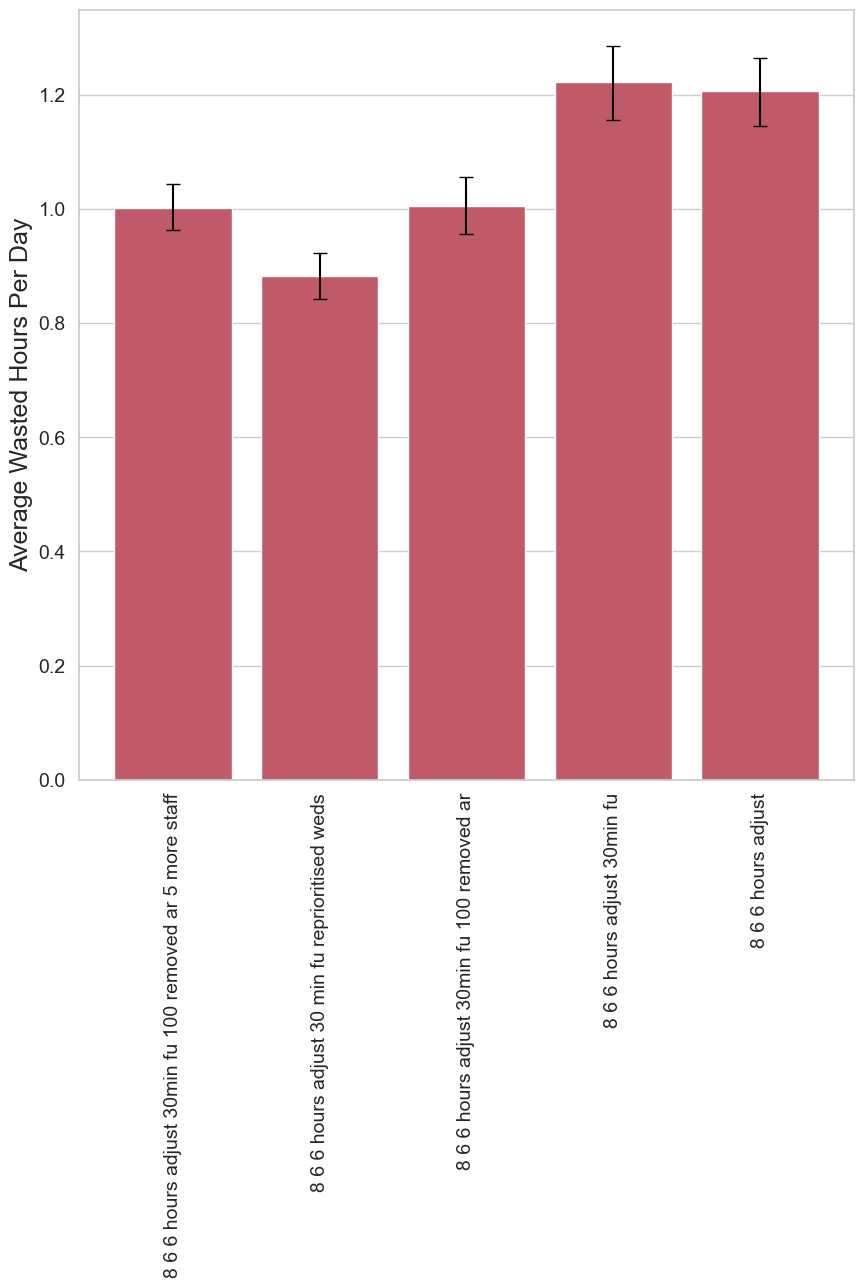

In [181]:
# wasted time

# max wait times
plt.figure(figsize=(10, 10))

dfs = []

for csv in csvs:
    if "wasted_time" in csv:
        df = pd.read_csv(csv, index_col=0)
        df["source"] = csv[:-16].replace("_", " ")
        dfs.append(df)

df = pd.concat(dfs)

staff_0_wasted_time = df.loc[0]

staff_0_wasted_time = staff_0_wasted_time.set_index("source").loc[data["source"]].reset_index()

sns.barplot(staff_0_wasted_time, x="source", y="mean", color=sfttoolbox.team_colours["red"]["hex"])

plt.xticks(rotation=90)

for row in staff_0_wasted_time[["mean", "lb", "ub"]].reset_index(drop=True).iterrows():
    plt.errorbar(
        row[0], row[1]["mean"], 
        yerr=[[row[1]["mean"] - row[1]["lb"]], [row[1]["ub"] - row[1]["mean"]]], 
        fmt='none', capsize=5, color='black', lw=1.5
    )
    
    
plt.xlabel("")
plt.ylabel("Average Wasted Hours Per Day", size=18)
plt.xticks(size=14)
plt.yticks(size=14)

plt.savefig("images/meta_wasted_time.png", dpi=600,  bbox_inches='tight')

{'red': {'hex': '#d1495b', 'rgb': 'RGB(209, 73, 91)'},
 'green': {'hex': '#66a182', 'rgb': 'RGB(102, 161, 130)'},
 'yellow': {'hex': '#edae49', 'rgb': 'RGB(237, 174, 73)'},
 'blue_grey': {'hex': '#9db2bf', 'rgb': 'RGB(157, 178, 191)'},
 'grey': {'hex': '#dde6ed', 'rgb': 'RGB(221, 230, 237)'},
 'blue': {'hex': '#00789c', 'rgb': 'RGB(0, 120, 156)'},
 'dark_blue': {'hex': '#27374d', 'rgb': 'RGB(39, 55, 77)'},
 'white': {'hex': '#ffffff', 'rgb': 'RGB(255, 255, 255)'}}

## Graph

In [235]:
sim.plot_graph("images/sample_graph.html")